# Ad Click Prediction

In this notebook, we will be analyzing ad click data from [Kaggle](https://www.kaggle.com/datasets/marius2303/ad-click-prediction-dataset) and building a prediction model.

***

# Initialization

Importing libraries, data etc...

In [1]:
# Setting PYTHONHASHSEED
import os

pyhashseed1 = os.environ.get('PYTHONHASHSEED')
os.environ['PYTHONHASHSEED'] = '0'
pyhashseed2 = os.environ.get('PYTHONHASHSEED')

# NOTEBOOK EXCLUSIVE CODE
if __name__ == "__main__":
    print('Make sure the following says \'None\': ', pyhashseed1)
    print('Make sure the following says \'0\': ', pyhashseed2)

Make sure the following says 'None':  None
Make sure the following says '0':  0


In [2]:
# Importing libraries
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from IPython.display import display

# Setting seed
np.random.seed(42)

In [3]:
# Displaying + saving plot function
IMAGES_PATH = Path() / 'plots'

def save_fig(fig_name, tight_layout=True, fig_extension='png', resolution=300):
    '''Saves an image to the plots folder with the specified name.'''
    path = IMAGES_PATH / f'{fig_name}.{fig_extension}'
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_show(plt_name):
    '''Saves an image using save_fig() under the plt_name and displays it.'''
    save_fig(plt_name)
    plt.show()

In [4]:
# Import data
adclicks = pd.read_csv("data/ad_click_dataset.csv")

***

# EDA + Splitting Data

This section will be a comprehensive analysis and cleaning of the data. We will examine its structure, remove redundant data, and examine relationships. We will also split the data into the training and test set.

## Data Overview

Structure of the dataset, % of missing/duplicate values etc..

In [5]:
# Grab a quick snapshot
adclicks.head()

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0


In [6]:
# Evaluate duplicate values
duplicates = adclicks.duplicated()
print("There are", len(adclicks[duplicates]), "duplicate rows.")

# Drop duplicates
adclicks = adclicks.drop_duplicates()
print("The duplicate rows have been dropped. There are", len(adclicks), "rows remaining.")

There are 2853 duplicate rows.
The duplicate rows have been dropped. There are 7147 rows remaining.


In [7]:
# General information
adclicks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7147 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7147 non-null   int64  
 1   full_name         7147 non-null   object 
 2   age               3671 non-null   float64
 3   gender            3747 non-null   object 
 4   device_type       5419 non-null   object 
 5   ad_position       5404 non-null   object 
 6   browsing_history  3667 non-null   object 
 7   time_of_day       5435 non-null   object 
 8   click             7147 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 558.4+ KB


## Data Cleaning + Data Visualization

Evaluate missing values and think about how to deal with them. Visualize distributions of features and conduct initial visual analysis.

### Missing Data

Examining missing values and thinking about how to deal with the missingness.

In [8]:
# How many missing values in each feature?
missing = adclicks.isna().sum()
display(missing)

# How many rows with missing values?
missing_rows_count = adclicks.isnull().any(axis=1).sum()
print(f"Number of rows with missing data: {missing_rows_count}")

id                     0
full_name              0
age                 3476
gender              3400
device_type         1728
ad_position         1743
browsing_history    3480
time_of_day         1712
click                  0
dtype: int64

Number of rows with missing data: 6707


/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1762/3238009911.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


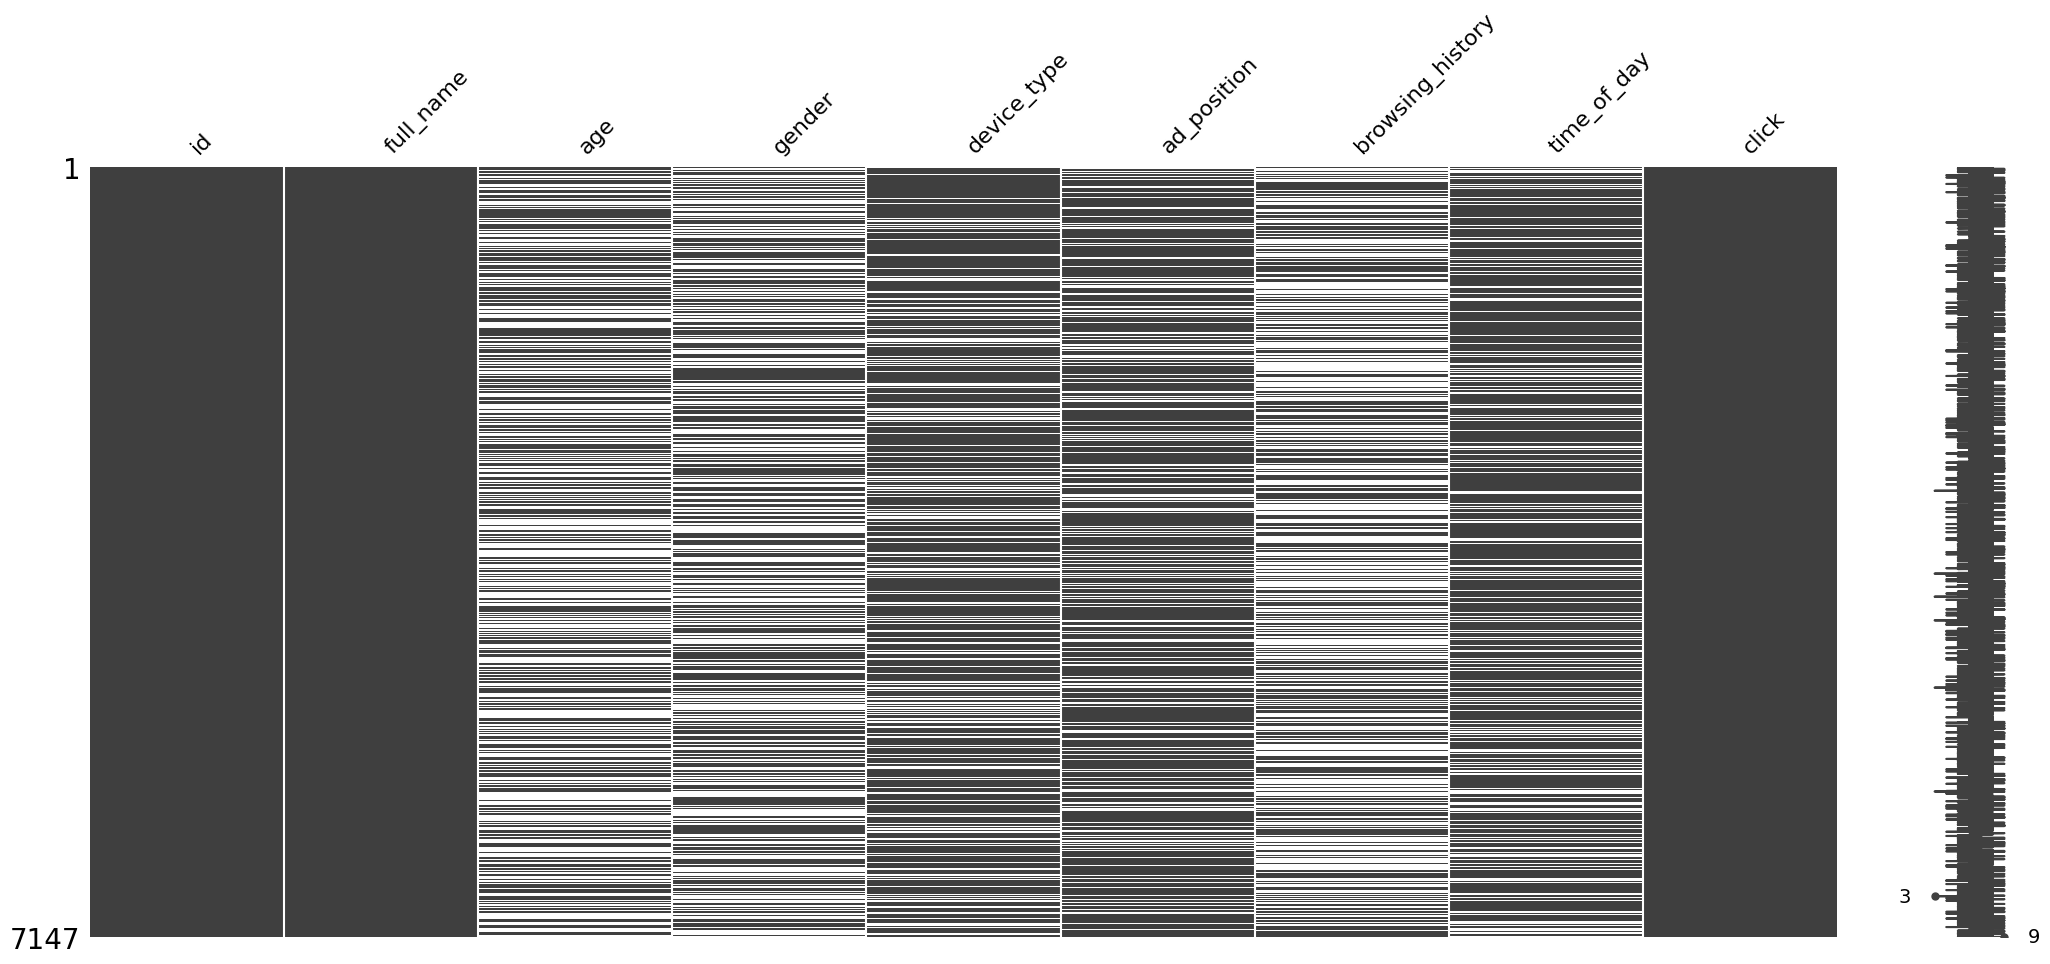

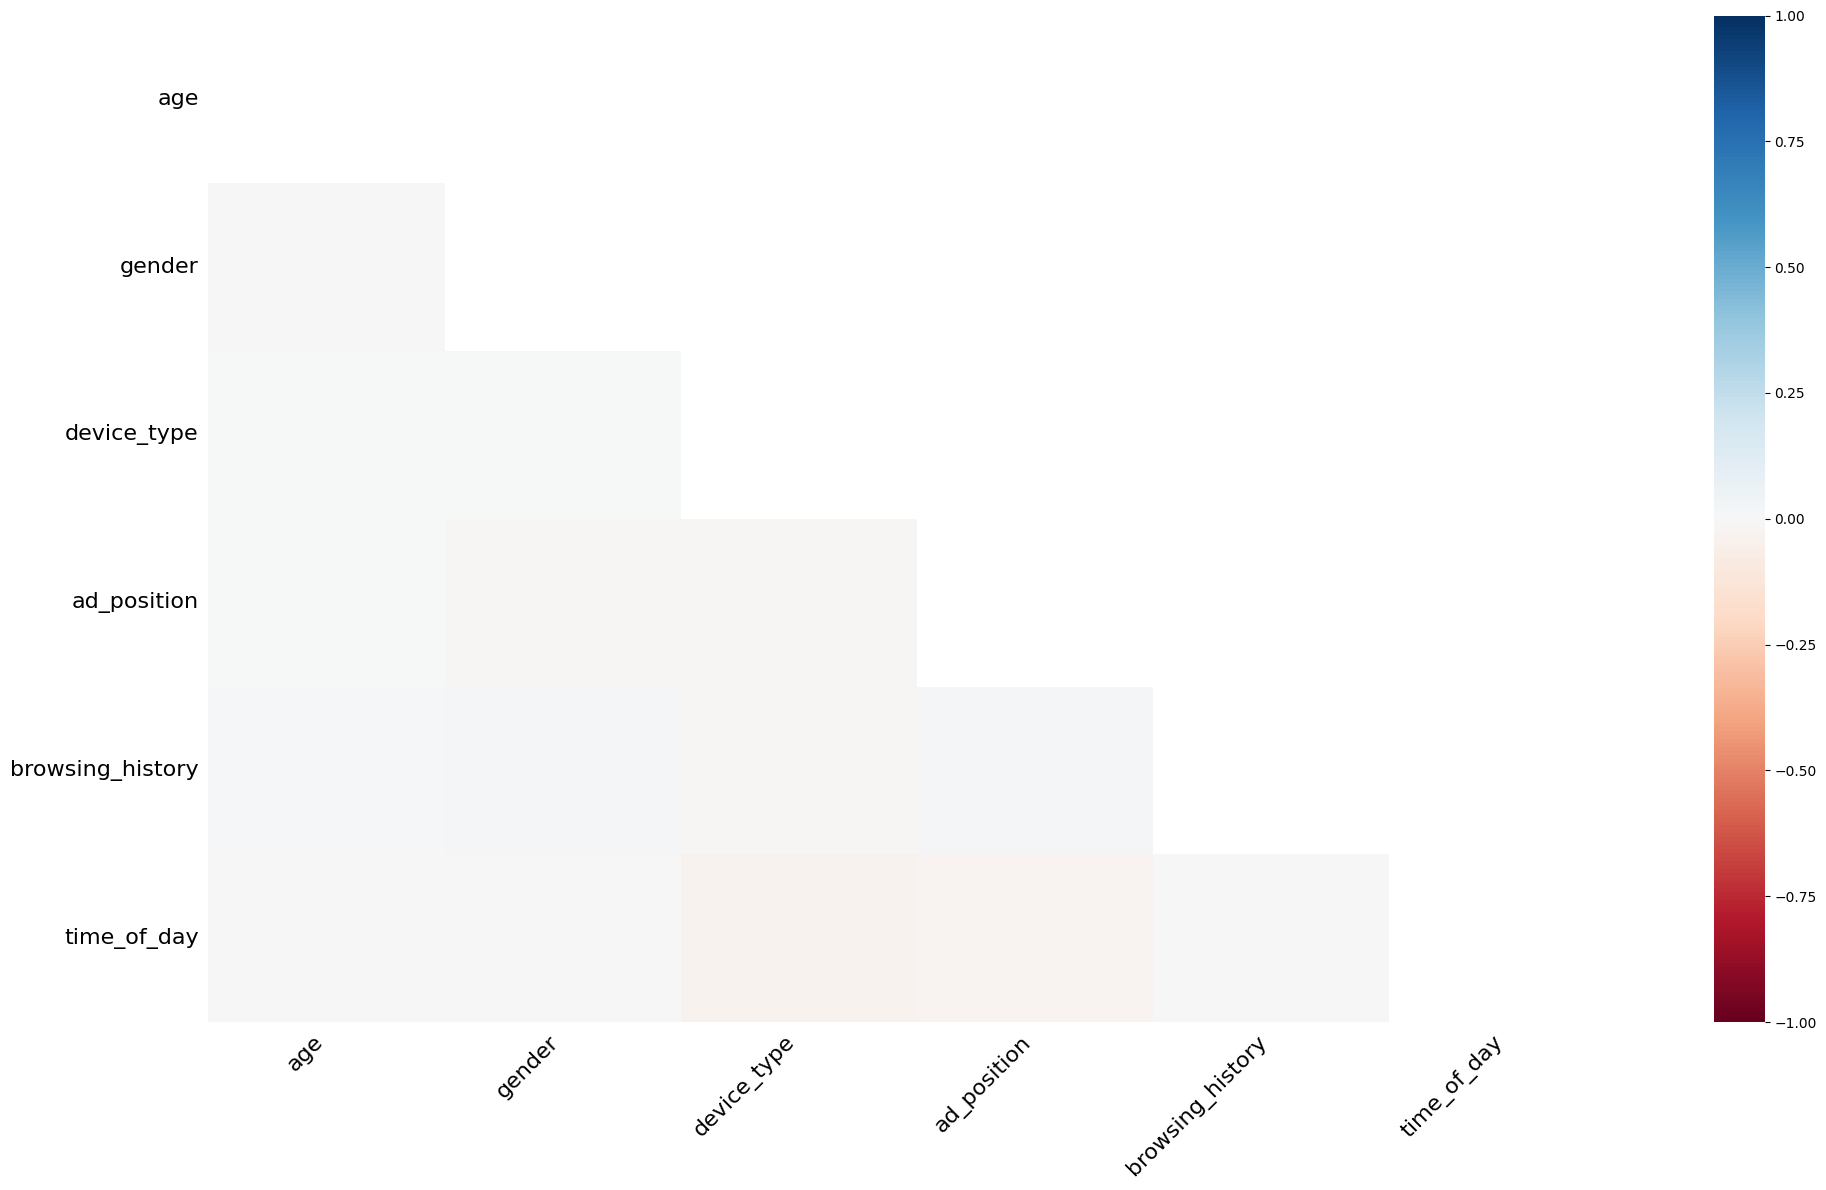

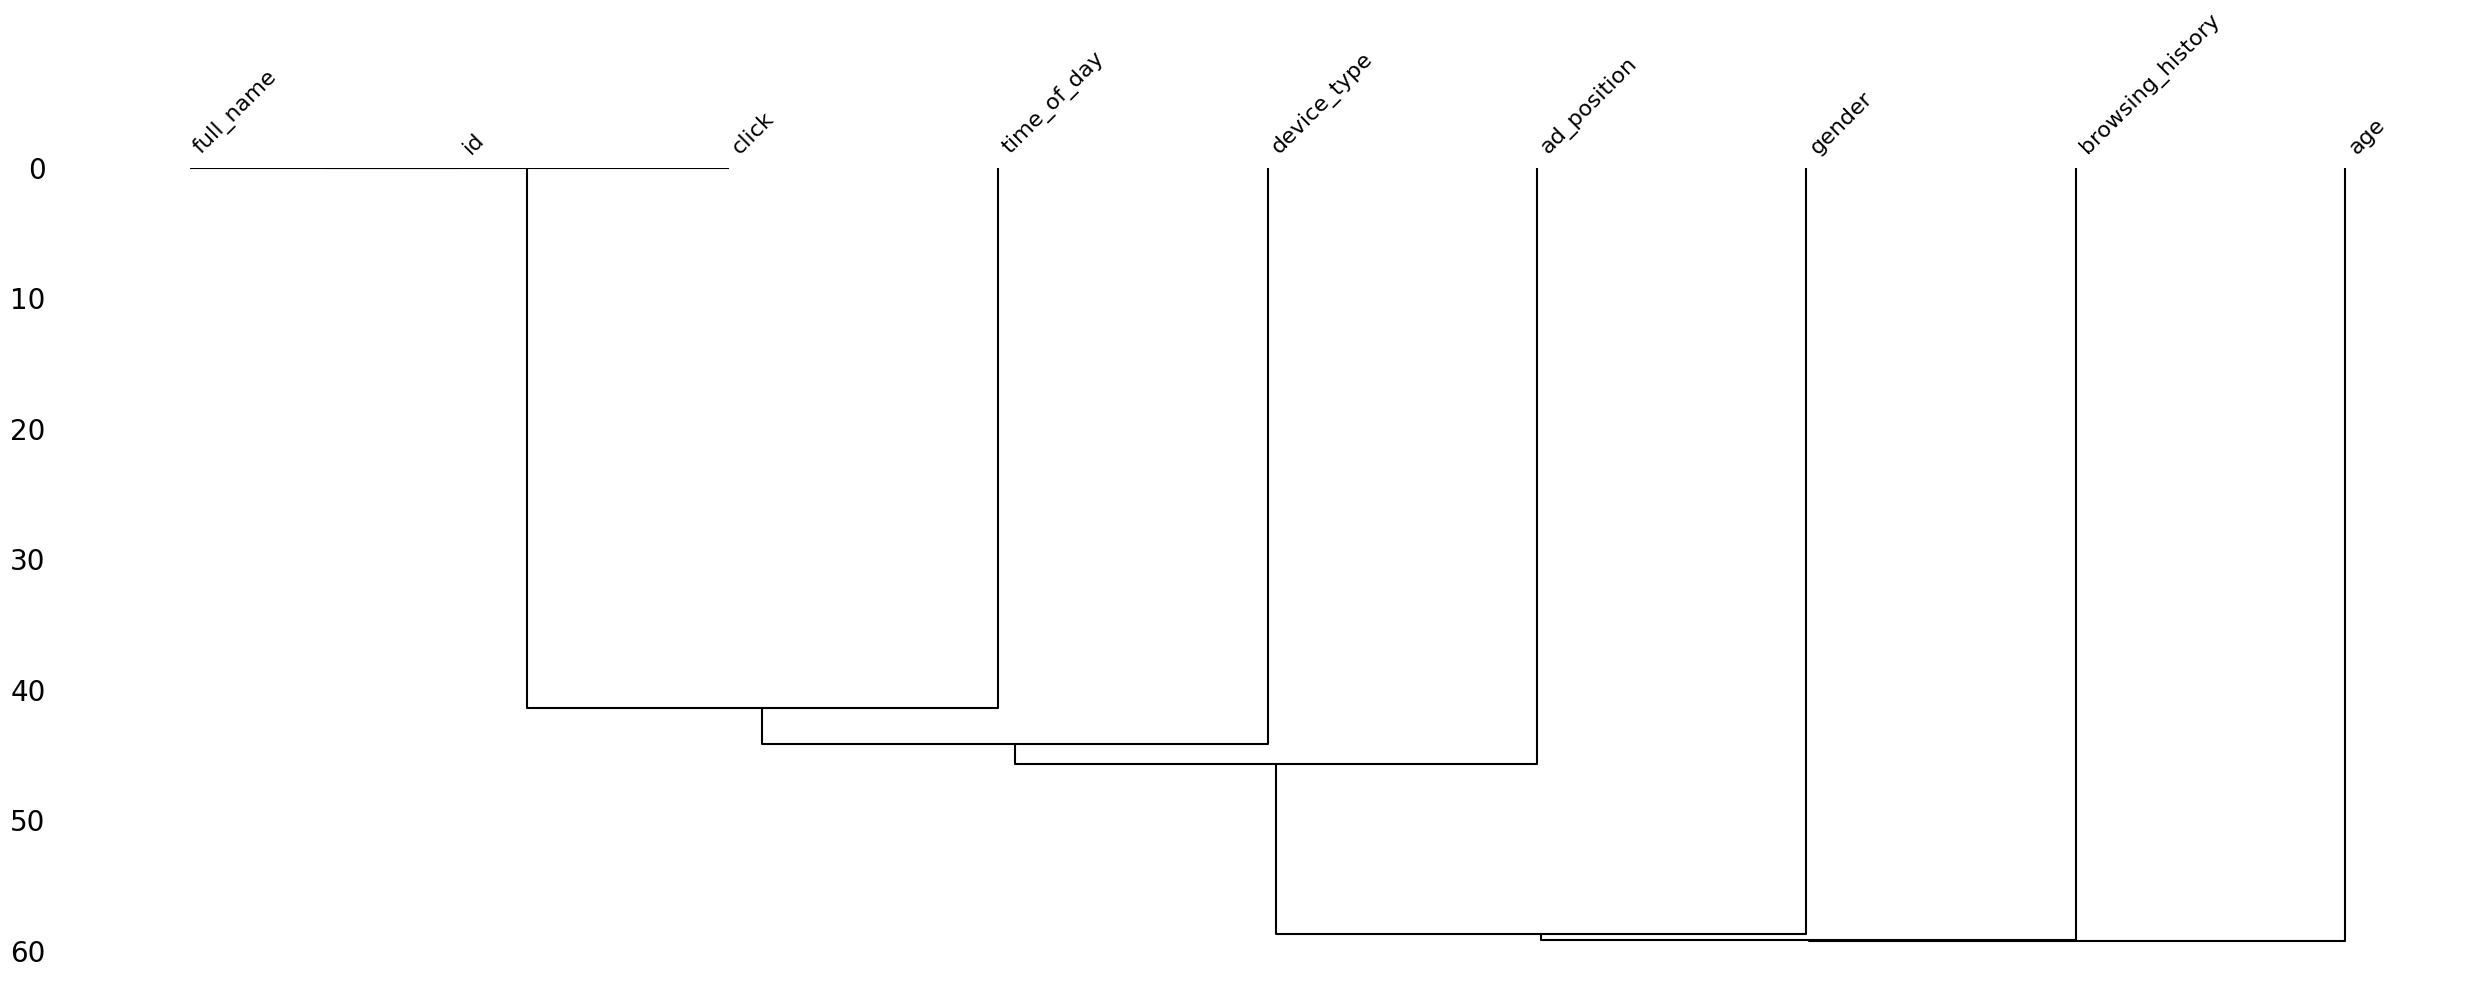

In [9]:
import missingno as msno

# Check pattern of missingness

# Missing matrix
msno.matrix(adclicks)
plot_show("missing_matrix")

# Nullity correlation heatmap
msno.heatmap(adclicks)
plot_show("nullity_corr_heatmap")

# Dendrogram
msno.dendrogram(adclicks)
plot_show("missing_dendrogram")

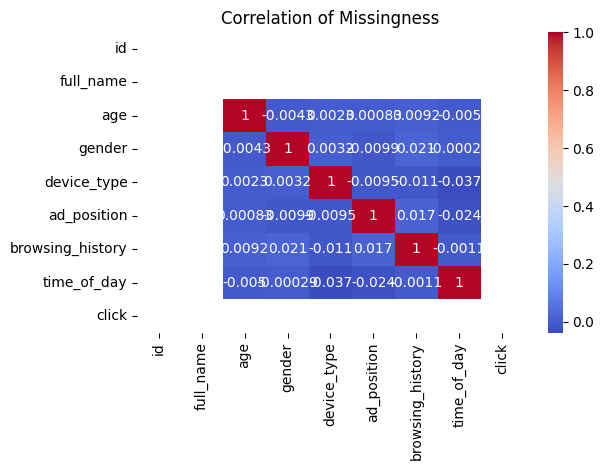

In [10]:
# Correlation heatmap for missingness
missing_corr = adclicks.isnull().corr()
sns.heatmap(missing_corr, annot=True, cmap="coolwarm")
plt.title("Correlation of Missingness")
plot_show("missing_correlation")

### Examining Unique Values

Examine the unique values of the categorical features and if any of the columns can serve as a row ID.

In [11]:
# Extract categorical columns
categorical = adclicks.select_dtypes(include=["object", "category", "bool"])

# Display unique values in each categorical column
for feature in categorical:
    print(f"{feature}: " ,list(categorical[feature].unique()))

full_name:  ['User670', 'User3044', 'User5912', 'User5418', 'User9452', 'User5942', 'User7808', 'User5065', 'User7993', 'User4509', 'User2595', 'User7466', 'User8171', 'User2023', 'User973', 'User7529', 'User8127', 'User188', 'User2124', 'User7335', 'User5569', 'User2272', 'User2722', 'User316', 'User9789', 'User4890', 'User4994', 'User5055', 'User6724', 'User8253', 'User4945', 'User1729', 'User6862', 'User4985', 'User7361', 'User1524', 'User2542', 'User119', 'User5881', 'User9642', 'User1171', 'User1612', 'User9586', 'User7661', 'User4228', 'User5574', 'User120', 'User6143', 'User301', 'User5301', 'User5439', 'User9806', 'User9888', 'User4525', 'User6153', 'User7498', 'User9736', 'User2244', 'User4952', 'User4855', 'User9590', 'User813', 'User4957', 'User9431', 'User6935', 'User2431', 'User3164', 'User4756', 'User7674', 'User6251', 'User6751', 'User9996', 'User2973', 'User6315', 'User7065', 'User9412', 'User3458', 'User6121', 'User487', 'User3266', 'User6553', 'User8996', 'User503', '

In [12]:
# Unique number of `id` and `full_name`
print(adclicks["id"].nunique())
print(adclicks["full_name"].nunique())

4000
4000


In [13]:
# Dropping `full_name`
adclicks = adclicks.drop(columns="full_name")

## Examining Recurring Users

Since we have recurring users, we are going to quickly examine their effect on the data to determine the best method of splitting.

In [14]:
# Extract recurring users
# Count `id` occurrences
id_counts = adclicks["id"].value_counts()
print(f"The maximum number of times a user occurs is {id_counts.max()}.")

# Separate recurring users and single users
recurring_ids = id_counts[id_counts > 1].index
recurring_users = adclicks[adclicks["id"].isin(recurring_ids)]
single_users = adclicks[~adclicks["id"].isin(recurring_ids)]

# Count occurrences of each
print(f"Total number of recurring users: {recurring_users["id"].nunique()}")
print(f"Total number of single users: {single_users["id"].nunique()}")

The maximum number of times a user occurs is 14.
Total number of recurring users: 500
Total number of single users: 3500


In [15]:
# Describe each dataset
print("Single User Statistics")
display(single_users.describe())
print("Recurring User Statistics")
display(recurring_users.describe())

Single User Statistics


,id,age,click
count,3500.000000,1883.000000,3500.0
mean,5022.290571,41.634095,0.0
std,2891.171737,13.472270,0.0
min,5.000000,18.000000,0.0
25%,2529.000000,30.000000,0.0
50%,5020.500000,42.000000,0.0
75%,7525.500000,53.000000,0.0
max,10000.000000,64.000000,0.0


Recurring User Statistics


,id,age,click
count,3647.000000,1788.000000,3647.0
mean,5060.473540,38.975951,1.0
std,2841.322173,12.802883,0.0
min,7.000000,18.000000,1.0
25%,2529.000000,28.000000,1.0
50%,5301.000000,38.000000,1.0
75%,7376.000000,49.250000,1.0
max,9992.000000,64.000000,1.0


## Distribution of Categorical Features

We will examine the distribution of the whole dataset and the users by category of occurrence.

In [16]:
# Function to create plot grid of barplots
def plot_barplots(dataframes, dataframe_names, features, colors):
    '''A function that outputs a grid of barplots.'''
    
    num_df = len(dataframes)
    num_features = len(features)
    
    # Each figure will be 6 by 4
    fig, axes = plt.subplots(num_features, num_df, figsize=(6*num_df, 4*num_features), sharey=True)
    
    # Iterate through and plot figures
    for i, ax in enumerate(axes.flatten()):
        # Gather data
        df = dataframes[i % num_df]
        df_name = dataframe_names[i % num_df]
        feature = features[i // num_df]
        feature_name = feature.capitalize()
        color = colors[i // num_df]
        
        # Configure data for sns
        counts = df[feature].value_counts(dropna=False).reset_index()
        counts.columns = [feature_name, "Count"]
        counts[feature_name] = counts[feature_name].fillna("Missing")   # Convert Na's to Missing
        
        # Create barplot
        sns.barplot(x=feature_name, y="Count", data=counts, color=color, ax=ax)
        
        # Extra plot details
        ax.set_title(f"{feature_name} Counts for {df_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Count")

        

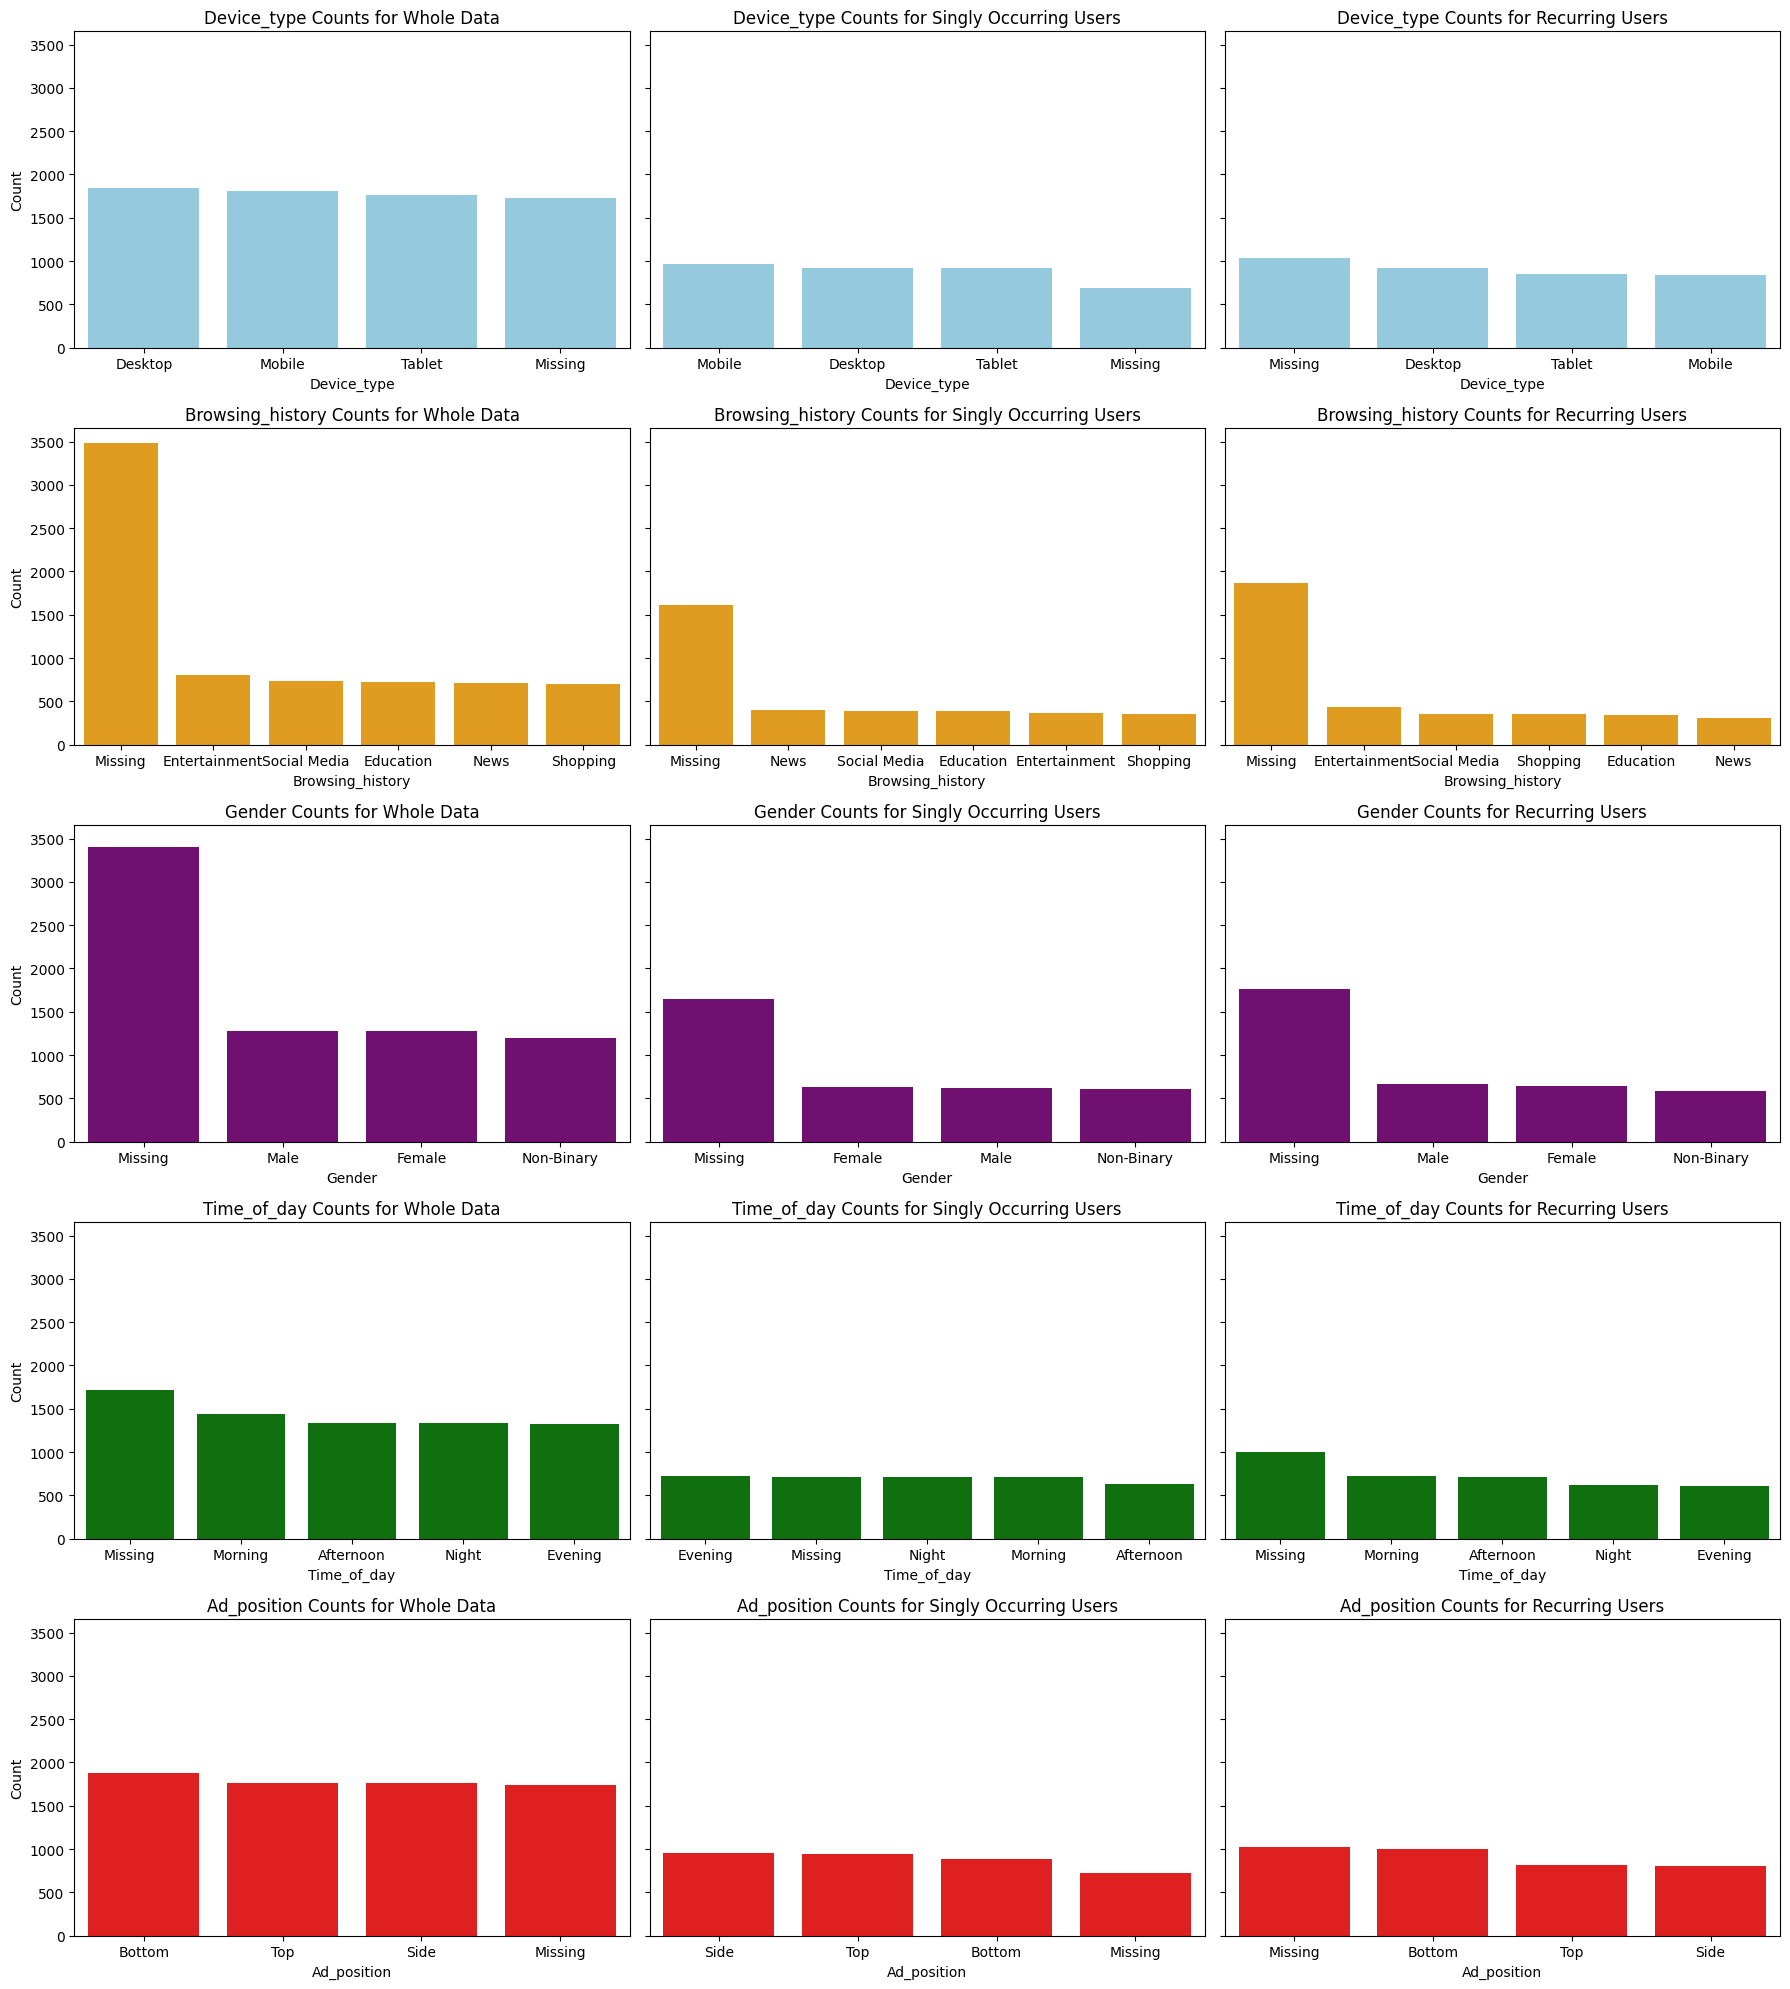

In [17]:
dataframes = [adclicks, single_users, recurring_users]
dataframe_names = ["Whole Data", "Singly Occurring Users", "Recurring Users"]
features = list(set(categorical).intersection(set(adclicks.columns)))
colors = ["skyblue", "orange", "purple", "green", "red"]

plot_barplots(dataframes, dataframe_names, features, colors)
plot_show("categorical_barplots")

## Distributions of Numerical Features

Evaluating the distribution of numerical features.

In [18]:
# Information of numerical features
adclicks.describe()

,id,age,click
count,7147.000000,3671.000000,7147.000000
mean,5041.774731,40.339417,0.510284
std,2865.705550,13.215682,0.499929
min,5.000000,18.000000,0.000000
25%,2529.000000,29.000000,0.000000
50%,5180.000000,40.000000,1.000000
75%,7454.000000,52.000000,1.000000
max,10000.000000,64.000000,1.000000


In [19]:
# Function to create plot grid of boxplots
def plot_boxplots(dataframes, dataframe_names, features, colors, group_by=None):
    '''A function that outputs a grid of boxplots.'''
    
    num_df = len(dataframes)
    num_features = len(features)
    
    # Each figure will be 6 by 4
    fig, axes = plt.subplots(num_features, num_df, figsize=(6*num_df, 4*num_features), sharey=True)
    
    # Iterate through and plot figures
    for i, ax in enumerate(axes.flatten()):
        # Gather data
        df = dataframes[i % num_df]
        df_name = dataframe_names[i % num_df]
        feature = features[i // num_df]
        feature_name = feature.capitalize()
        color = colors[i // num_df]
        
        # Create barplot
        sns.boxplot(x=group_by, y=feature, data=df, color=color, ax=ax)
        
        # Extra plot details
        ax.set_title(f"{feature_name} Boxplot for {df_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel(group_by)


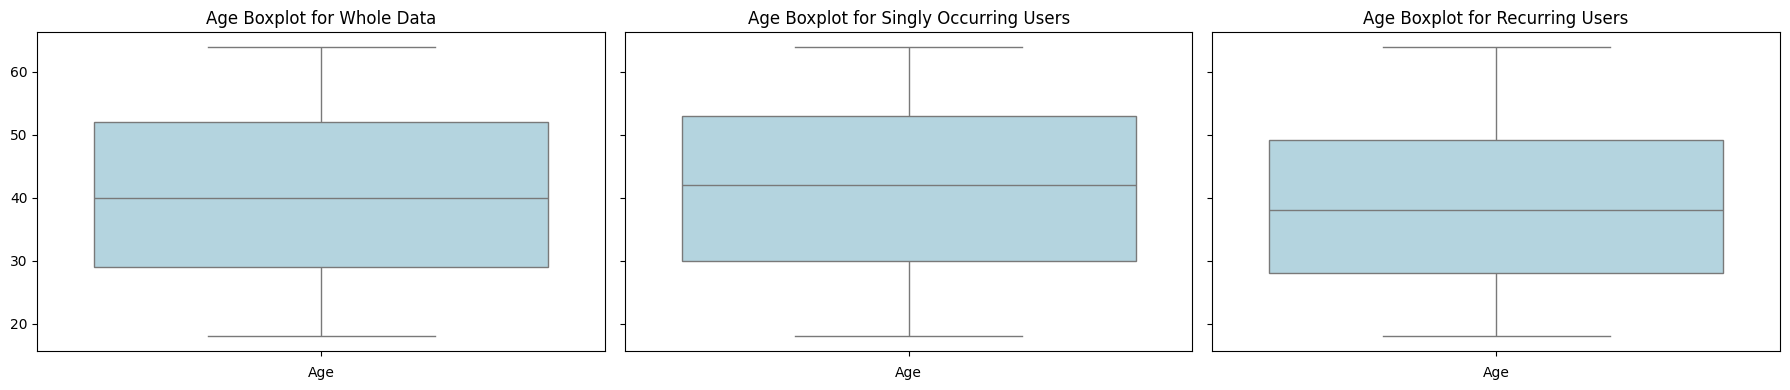

In [20]:
# Boxplot of age with user category by occurrence
features = ["age"]
colors = ["lightblue"]

plot_boxplots(dataframes, dataframe_names, features, colors)
plot_show("age_boxplots")

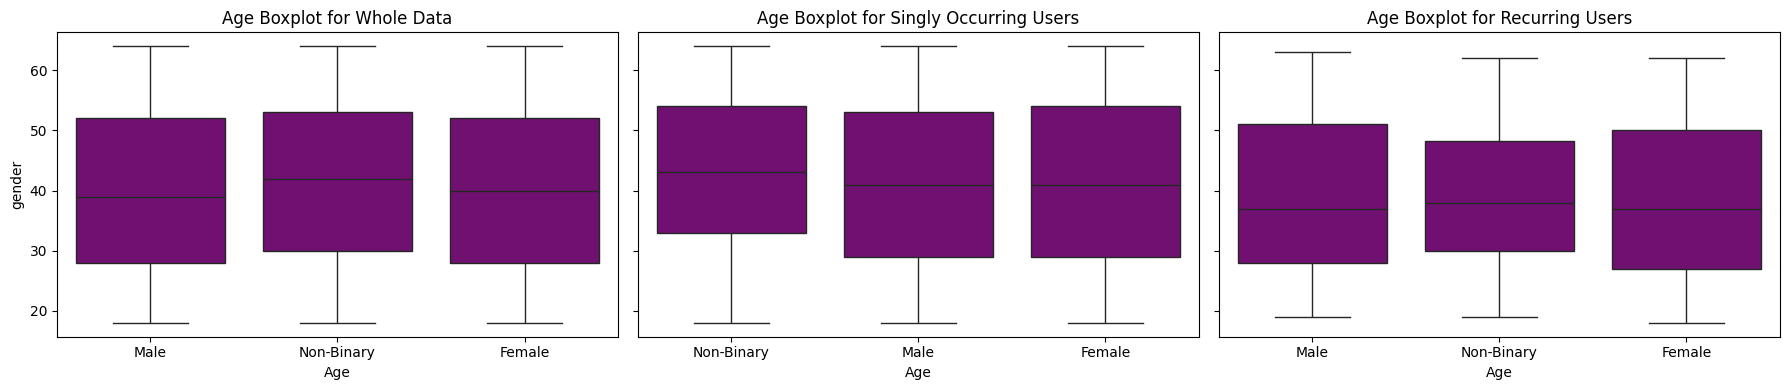

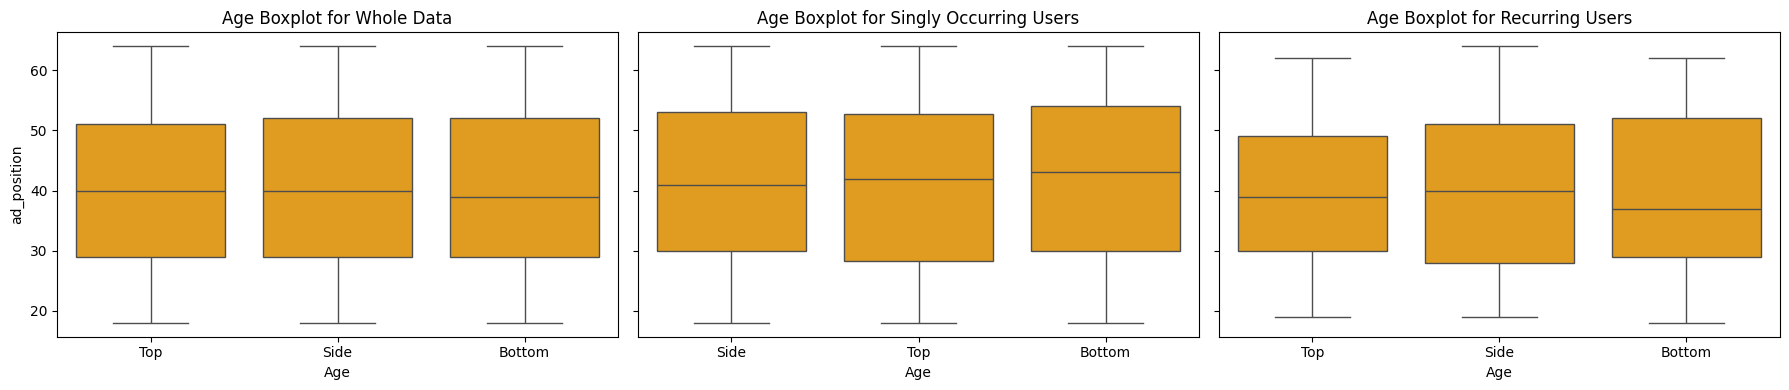

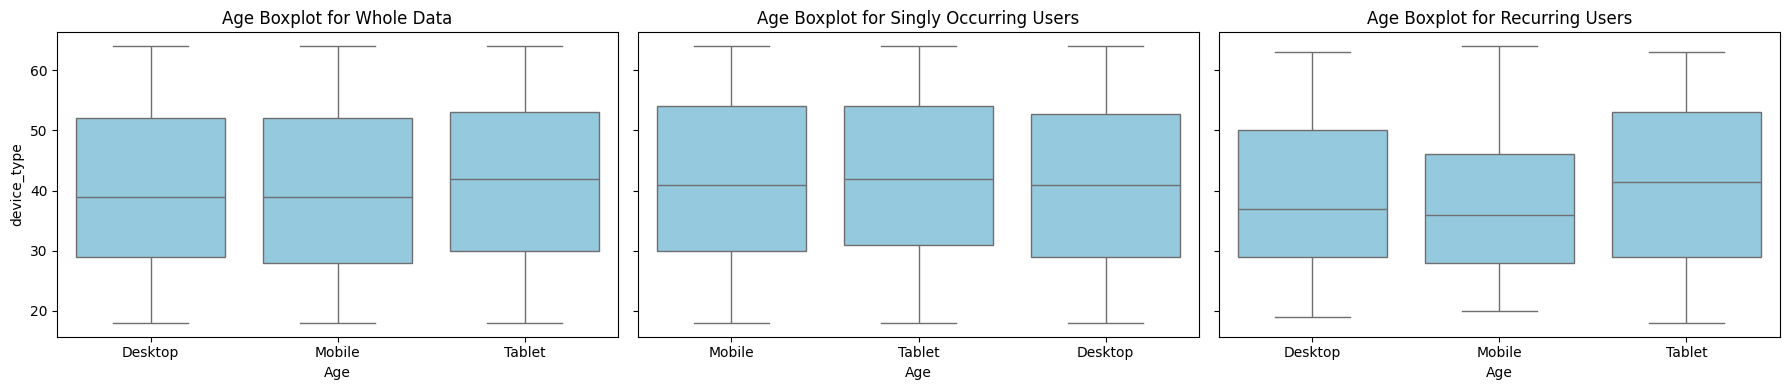

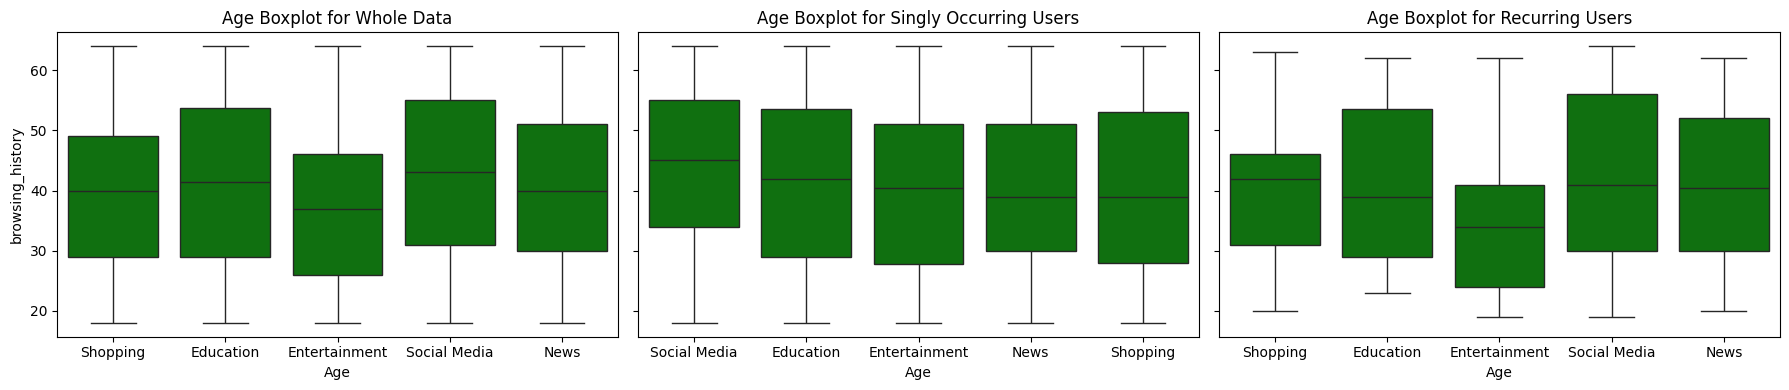

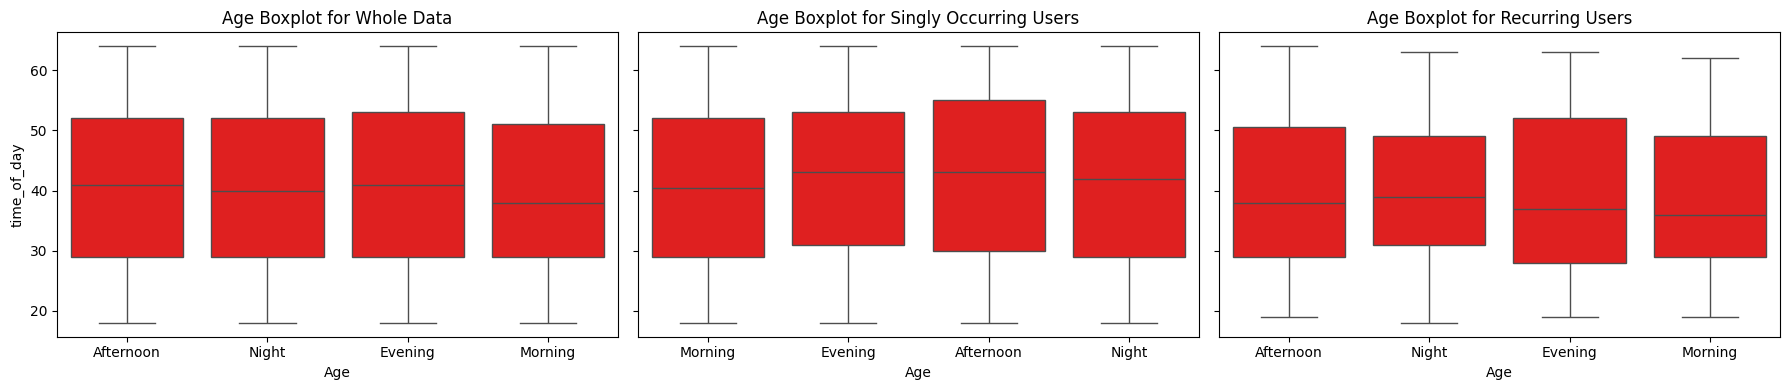

In [21]:
# Gender vs Age
plot_boxplots(dataframes, dataframe_names, features, ["purple"], group_by="gender")
plot_show("age_vs_gender_boxplots")

# Ad Position vs Age
plot_boxplots(dataframes, dataframe_names, features, ["orange"], group_by="ad_position")
plot_show("age_vs_ad_position_boxplots")

# Device Type vs Age
plot_boxplots(dataframes, dataframe_names, features, ["skyblue"], group_by="device_type")
plot_show("age_vs_device_type_boxplots")

# Browsing History vs Age
plot_boxplots(dataframes, dataframe_names, features, ["green"], group_by="browsing_history")
plot_show("age_vs_browsing_history_boxplots")

# Time of Day vs Age
plot_boxplots(dataframes, dataframe_names, features, ["red"], group_by="time_of_day")
plot_show("age_vs_time_of_day_boxplots")

In [22]:
# Function to create plot grid of histograms
def plot_histograms(dataframes, dataframe_names, features, colors):
    '''A function that outputs a grid of histograms.'''
    
    num_df = len(dataframes)
    num_features = len(features)
    
    # Each figure will be 6 by 4
    fig, axes = plt.subplots(num_features, num_df, figsize=(6*num_df, 4*num_features), sharey=True)
    
    # Iterate through and plot figures
    for i, ax in enumerate(axes.flatten()):
        # Gather data
        df = dataframes[i % num_df]
        df_name = dataframe_names[i % num_df]
        feature = features[i // num_df]
        feature_name = feature.capitalize()
        color = colors[i // num_df]
        
        # Create barplot
        sns.histplot(x=feature, data=df, kde=True, color=color, ax=ax)
        
        # Extra plot details
        ax.set_title(f"{feature_name} Histogram for {df_name}")
        ax.set_xlabel(feature_name)


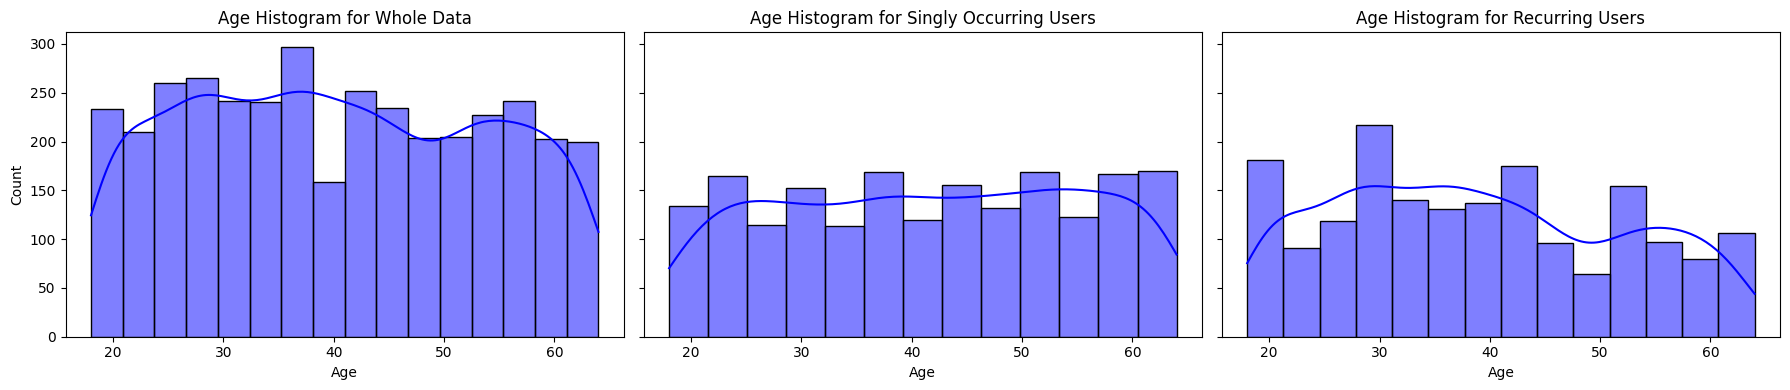

In [23]:
# Histogram of age with user category by occurrence
features = ["age"]
colors = ["blue"]

plot_histograms(dataframes, dataframe_names, features, colors)
plot_show("age_histograms")

***

# Preprocessing Before Splitting

Preprocess data by imputing and encoding in multiple ways for different types of models.

## Aggregating and Collapsing Recurring User Data

In [24]:
# Aggregate and collapse recurring user data
recurring_users = recurring_users.fillna("Missing")

# Add `num_visits` column to represent the number of times a user visited
recurring_users["num_visits"] = recurring_users["id"].map(recurring_users["id"].value_counts())
single_users.loc[:,"num_visits"] =  1

recurring_users_collapsed = recurring_users.groupby("id").agg(lambda x: list(set(x).difference({"Missing"})))
recurring_users_collapsed = recurring_users_collapsed.map(lambda x: x[0] if isinstance(x, list) and x else np.nan).reset_index()

/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1762/127641155.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_users.loc[:,"num_visits"] =  1


In [25]:
# Add `recurring_user` column to both recurring and singly occuring users
recurring_users_collapsed.loc[:,"recurring_user"] = 1
single_users.loc[:,"recurring_user"] = 0

/var/folders/vd/7yzb859x5958jxfslq9bq57r0000gn/T/ipykernel_1762/249430633.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_users.loc[:,"recurring_user"] = 0


In [26]:
# Combine data
adclicks_users = pd.concat([single_users, recurring_users_collapsed], ignore_index=True)

## Drop `id`

Since we know each row is a unique user, we can drop `id`.

In [27]:
# Drop `id`
adclicks_users = adclicks_users.drop(columns="id")

## Two Datasets: Imputation vs. Missing category

In [28]:
# Imputation dataset
adclicks2 = adclicks_users

# Complete dataset
adclicks3 = adclicks_users[adclicks_users.columns.difference(["age"])].fillna("Missing")
adclicks3.loc[:, "age"] = adclicks_users[["age"]]
reorder = ["age", "gender", "device_type", "ad_position", "browsing_history", "time_of_day", "click", "num_visits", "recurring_user"]
adclicks3 = adclicks3[reorder]

***

# Splitting data

Split the data with respect to the class imbalance of `click`.

In [29]:
# Downsampling
from sklearn.utils import resample

# Split `adclicks2` and then separate indices from `adclicks3`
adclicks2_majority = adclicks2[adclicks2.click == 0]
adclicks2_minority = adclicks2[adclicks2.click == 1]

adclicks2_majority_ds = resample(adclicks2_majority, replace=False, n_samples=len(adclicks2_minority), random_state=42)
adclicks2_ds = pd.concat([adclicks2_majority_ds, adclicks2_minority])

In [30]:
# Extract same indices from `adclicks3`
adclicks3_ds = adclicks3.loc[adclicks2_ds.index]

In [31]:
# Split data
from sklearn.model_selection import train_test_split

X2 = adclicks3_ds.drop(columns="click")
y2 = adclicks3_ds["click"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=42, test_size=0.2)

In [32]:
# Extract same indices from `adclicks3_ds`
X3 = adclicks3_ds.drop(columns="click")
y3 = adclicks3_ds["click"]

X3_train = X3.loc[X2_train.index]
X3_test = X3.loc[X2_test.index]
y3_train = y3.loc[y2_train.index]
y3_test = y3.loc[y2_test.index]

## Checking class imbalanace

In [33]:
# Function to create plot grid of barplots
def plot_barplots2(dataframes, dataframe_names, features, colors):
    '''A function that outputs a grid of barplots.'''
    
    num_df = len(dataframes)
    num_features = len(features)
    
    # Each figure will be 6 by 4
    fig, axes = plt.subplots(num_features, num_df, figsize=(6*num_df, 4*num_features), sharey=True)
    
    # Iterate through and plot figures
    for i, ax in enumerate(axes.flatten()):
        # Gather data
        df = dataframes[i % num_df]
        df_name = dataframe_names[i % num_df]
        feature = features[i // num_df]
        feature_name = feature.capitalize()
        color = colors[i // num_df]
        
        # Configure data for sns
        counts = df[feature].value_counts(dropna=False).reset_index()
        counts.columns = [feature_name, "Count"]
        counts[feature_name] = counts[feature_name].fillna("Missing")   # Convert Na's to Missing
        
        # Create barplot
        sns.barplot(x=feature_name, y="Count", data=counts, color=color, ax=ax)
        
        # Extra plot details
        ax.set_title(f"{feature_name} Counts for {df_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Count")

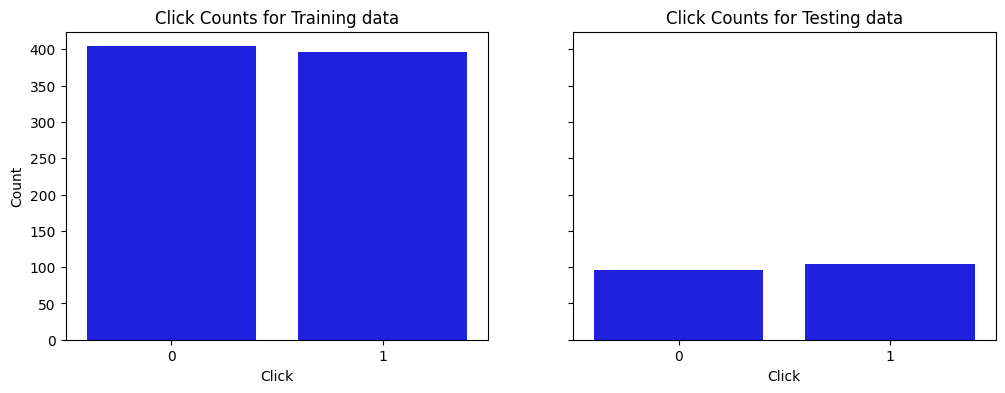

In [34]:
# Checking class imbalance
series = [y2_train, y2_test]
series_names = ["Training data", "Testing data"]

fig, axes = plt.subplots(1, 2, figsize=(6*2, 4*1), sharey=True)

# Iterate through and plot figures
for i, ax in enumerate(axes.flatten()):
    # Gather data
    srs = series[i % 2]
    srs_name = series_names[i % 2]
    feature_name = "Click"
    color = "blue"
    
    # Configure data for sns
    counts = srs.value_counts(dropna=False).reset_index()
    counts.columns = [feature_name, "Count"]
    counts[feature_name] = counts[feature_name].fillna("Missing")   # Convert Na's to Missing
    
    # Create barplot
    sns.barplot(x=feature_name, y="Count", data=counts, color=color, ax=ax)
    
    # Extra plot details
    ax.set_title(f"{feature_name} Counts for {srs_name}")
    ax.set_xlabel(feature_name)
    ax.set_ylabel("Count")

***

# Preprocessing after splitting

Preprocess by imputing missing data, encoding categorical variables, scaling numerical variables.

In [52]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder

from feature_engine.imputation import RandomSampleImputer

In [53]:
# Transformer Pipeline
num_transformer1 = Pipeline(
    steps =[
        ("imputed", RandomSampleImputer(random_state=42))
    ]
)

num_transformer2 = Pipeline(
    steps =[
        ("imputed", RandomSampleImputer(random_state=42)),
        ("scaled", MinMaxScaler())
    ]
)

preprocessor1 = ColumnTransformer(
    transformers=[
        ("encoding", OneHotEncoder(), ["gender", "device_type", "browsing_history", "ad_position", "time_of_day"]),
        ("num", num_transformer1, ["age"])
    ],
    remainder="passthrough"
)

preprocessor2 = ColumnTransformer(
    transformers=[
        ("encoding", OneHotEncoder(), ["gender", "device_type", "browsing_history", "ad_position", "time_of_day"]),
        ("num", num_transformer2, ["age", "num_visits"])
    ],
    remainder="passthrough"
)

In [57]:
scaled_df = preprocessor1.fit_transform(X3_train, y3_train)
scaled_df_columns = preprocessor1.get_feature_names_out()

scaled_df = pd.DataFrame(scaled_df, columns=scaled_df_columns)

In [58]:
non_scaled_df = preprocessor2.fit_transform(X3_train, y3_train)
# result = result.toarray()
non_scaled_df_columns = preprocessor2.get_feature_names_out()

non_scaled_df = pd.DataFrame(non_scaled_df, columns=non_scaled_df_columns)

***

# Feature Selection

We will look at the correlation of the features to see if we should introduce any feature reduction techniques.

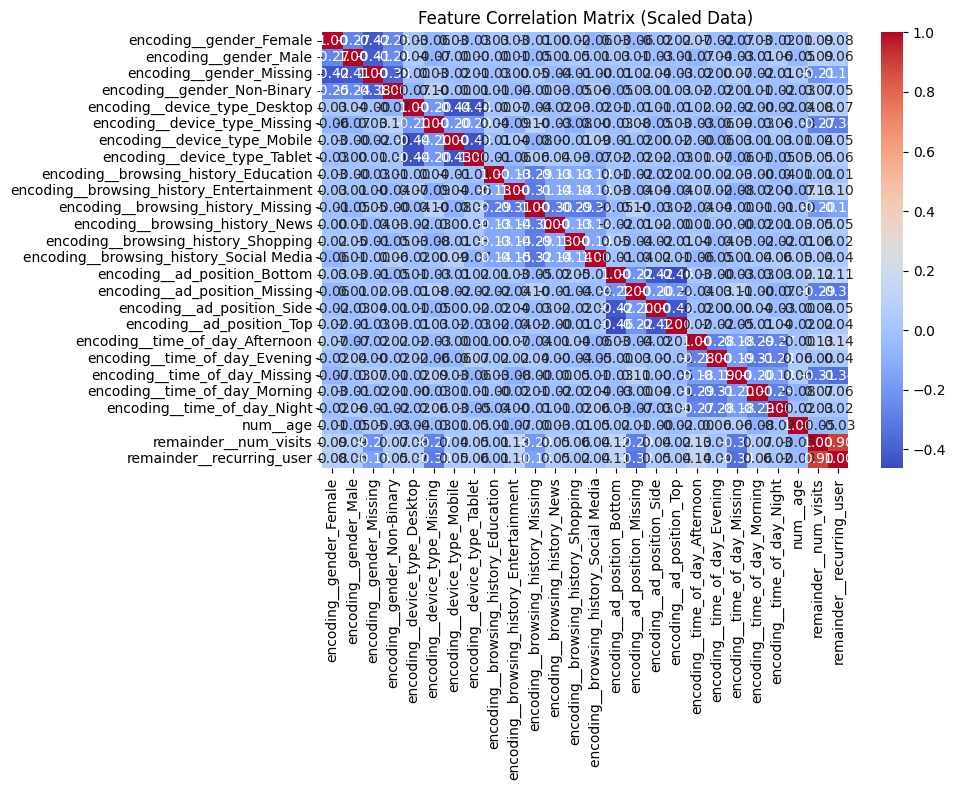

In [64]:
# Correlation matrix for scaled data
correlation_matrix = scaled_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix (Scaled Data)")
plot_show("scaled_feature_corr_matrix")

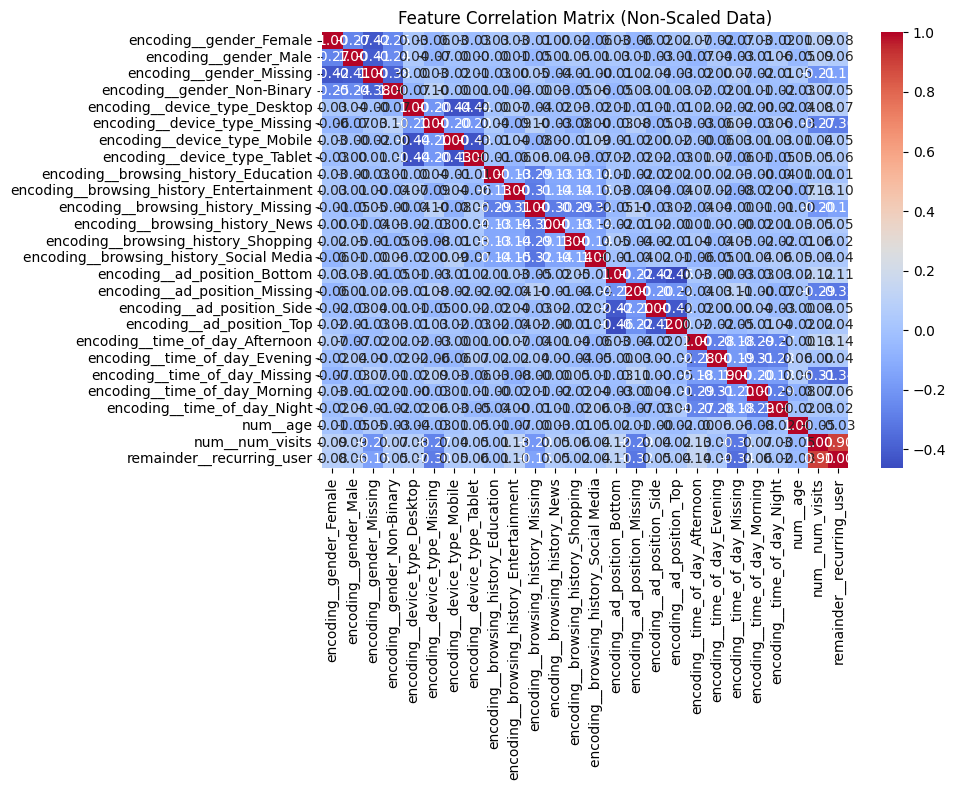

In [65]:
# Correlation matrix for non-scaled data
correlation_matrix = non_scaled_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix (Non-Scaled Data)")
plot_show("non_scaled_feature_corr_matrix")

***

# Running Models with Cross Validation

**I will be running models on the split datasets from `adclicks3`. If `adclicks3` is not performing well even after tuning and evaluation, we will go back to `adclicks2` and see if the model improves.**

In [56]:
# Creating a pd dataframe to store model metrics
metrics_store = list()

In [66]:
# Initializing cross validation
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Logistic regression pipeline
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor2),
    ('classifier', LogisticRegression(random_state=42))
])

# fit_pipeline("LogisticRegression", logreg_pipeline, metrics_store, X3_train, X3_test, y3_train, y3_test)

logreg_pipeline.fit(X3_train, y3_train)
# Predict
y_pred = logreg_pipeline.predict(X3_test)
y_prob = logreg_pipeline.predict_proba(X3_test)[:, 1]

# Evaluation metrics
metrics = {
    "model" : "LogisticRegression",
    "accuracy" : accuracy_score(y3_test, y_pred),
    "precision": precision_score(y3_test, y_pred),
    "recall" : recall_score(y3_test, y_pred),
    "f1" : f1_score(y3_test, y_pred),
    "auc" : roc_auc_score(y3_test, y_prob)
}
metrics_store.append(metrics)

# Plot ROC curve
fpr, tpr, threshold = roc_curve(y3_test, y_prob)
auc = roc_auc_score(y3_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()


metrics = pd.DataFrame(metrics_store)

In [ ]:
from xgboost import XGBClassifier

# Logistic regression pipeline
xgbc_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor1),
    ('classifier', XGBClassifier(random_state=42))
])

xgbc_pipeline.fit(X3_train, y3_train)
# Predict
y_pred = xgbc_pipeline.predict(X3_test)
y_prob = xgbc_pipeline.predict_proba(X3_test)[:, 1]

# Evaluation metrics
metrics = {
    "model" : "XGBClassifier",
    "accuracy" : accuracy_score(y3_test, y_pred),
    "precision": precision_score(y3_test, y_pred),
    "recall" : recall_score(y3_test, y_pred),
    "f1" : f1_score(y3_test, y_pred),
    "auc" : roc_auc_score(y3_test, y_prob)
}
metrics_store.append(metrics)

# Plot ROC curve
fpr, tpr, threshold = roc_curve(y3_test, y_prob)
auc = roc_auc_score(y3_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.show()


metrics = pd.DataFrame(metrics_store)